In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
CONDITIONS = ['0h', '5h', '10h', '15h', '20h', '24h']

output_dict = {}
cost_data = {}
bin_data = {}
power_flow_data = {}
storage_data = {}

for condition in CONDITIONS:
    file = pd.read_csv('../data/postprocessing/230822_compare_forced_bhkw_operation/output_time_series_' + condition + '.csv', index_col=0)
    output_dict[condition] = file

    gas_costs = file['bhkw_gas'] * file['gas_price']
    power_costs = file['net_power'].where(file['net_power'] <= 0, 0) * file['power_price']
    power_revenue = file['net_power'].where(file['net_power'] >= 0, 0) * file['power_price']

    power_flow_data[condition] = {}

    for name in file.columns:
        if '_con_' in name:
            con_dict = {name: file[name]}
            power_flow_data[condition].update(con_dict)
    
    costs = gas_costs - power_costs - power_revenue

    cost_data[condition] = (costs, gas_costs, power_costs, power_revenue)
    bin_data[condition] = file['bhkw_bin'].sum()

    storage_content = file['storage_energy']
    # print(storage_content)
    # print(type(storage_content))
    storage_content = pd.concat([storage_content, pd.Series([0], index= [0])]).sort_index()

    storage_data[condition] = storage_content

### Plot energy demand and power generation

Gas consumption

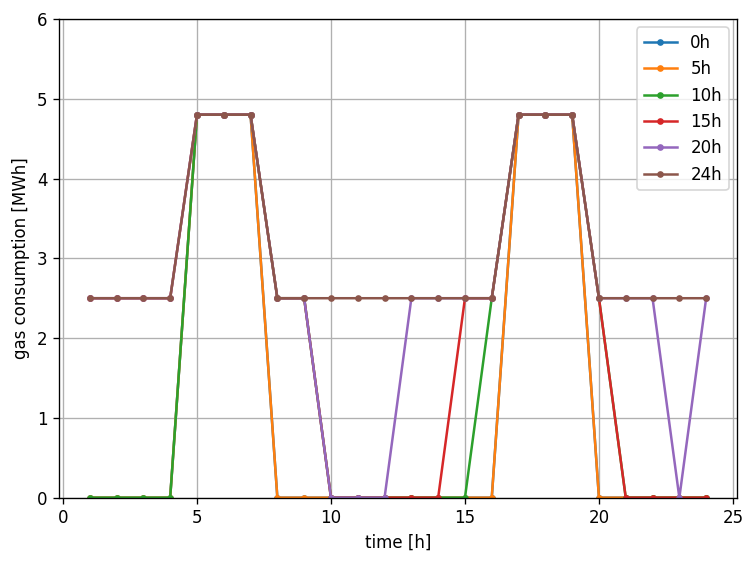

In [4]:
fig, ax = plt.subplots(dpi=120)
for key in output_dict.keys():
    output_dict[key]['bhkw_gas'].plot(style=".-", label=key)
ax.set_xlabel('time [h]')
ax.set_ylabel('gas consumption [MWh]')
ax.set_ylim(0, 6)
ax.legend()
ax.grid()

fig.tight_layout()

Net power feed in

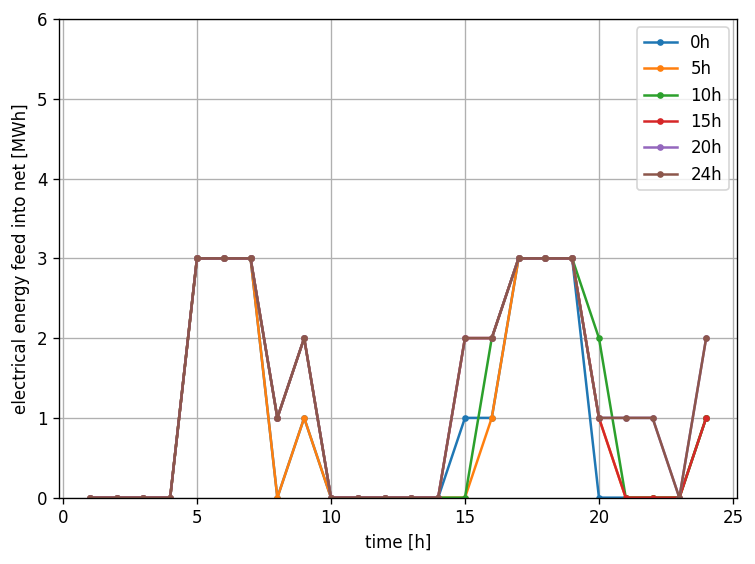

In [5]:
fig, ax = plt.subplots(dpi=120)

for key in output_dict.keys():
    output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0).plot(style=".-", label=key)
ax.set_xlabel('time [h]')
ax.set_ylabel('electrical energy feed into net [MWh]')
ax.set_ylim(0, 6)
ax.legend()
ax.grid()

fig.tight_layout()

Net power supply

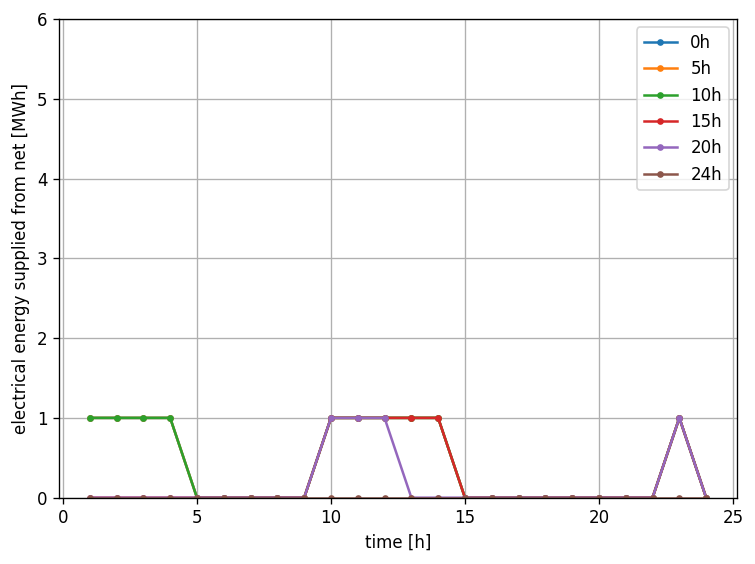

In [6]:
fig, ax = plt.subplots(dpi=120)
for key in output_dict.keys():
    (-1 * output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0)).plot(style=".-", label=key)
ax.set_xlabel('time [h]')
ax.set_ylabel('electrical energy supplied from net [MWh]')
ax.set_ylim(0, 6)
ax.legend()
ax.grid()

fig.tight_layout()

### Plot cost components

Gas and Power Price

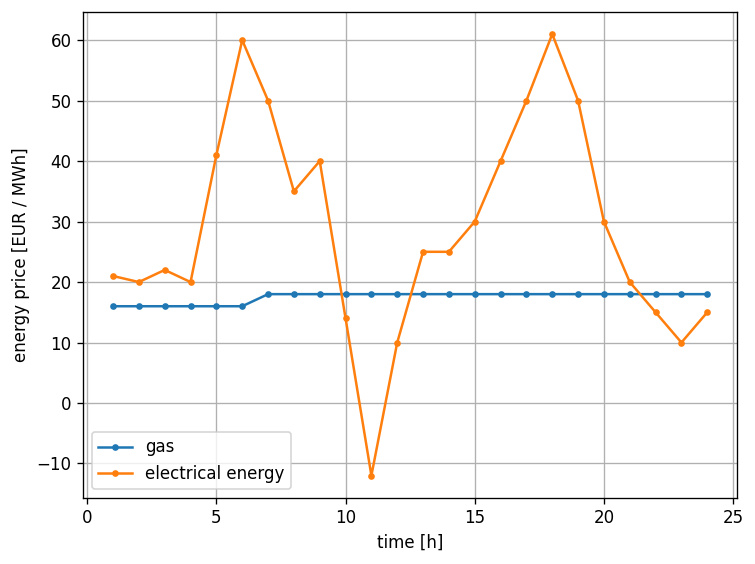

In [7]:
fig, ax = plt.subplots(dpi=120)
output_dict['0h']['gas_price'].plot(style=".-", label='gas')
output_dict['0h']['power_price'].plot(style=".-", label='electrical energy')
ax.set_xlabel('time [h]')
ax.set_ylabel('energy price [EUR / MWh]')
ax.legend()
ax.grid()

fig.tight_layout()

Gas costs

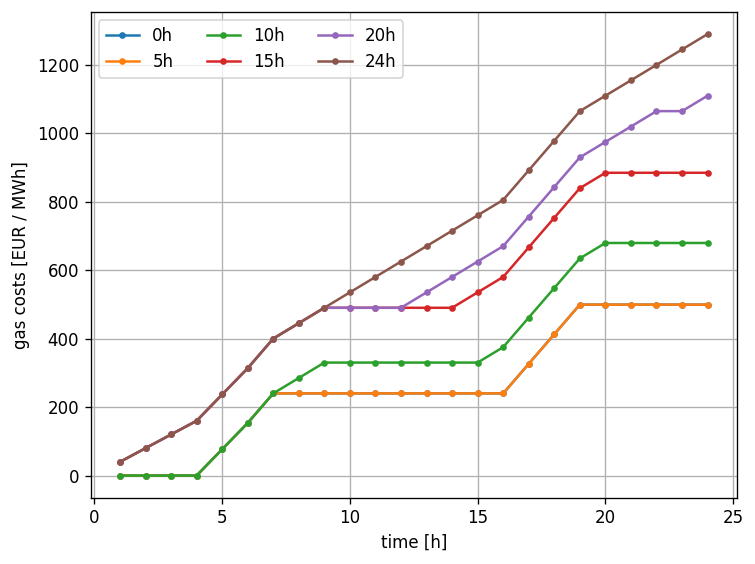

In [8]:
fig, ax = plt.subplots(dpi=120)

for key in output_dict.keys():
    (output_dict[key]['gas_price'] * output_dict[key]['bhkw_gas']).cumsum().plot(style=".-", label=key)

ax.set_ylabel('gas costs [EUR / MWh]')
ax.set_xlabel('time [h]')
ax.legend(ncol=3)
ax.grid()

fig.tight_layout()

Power costs

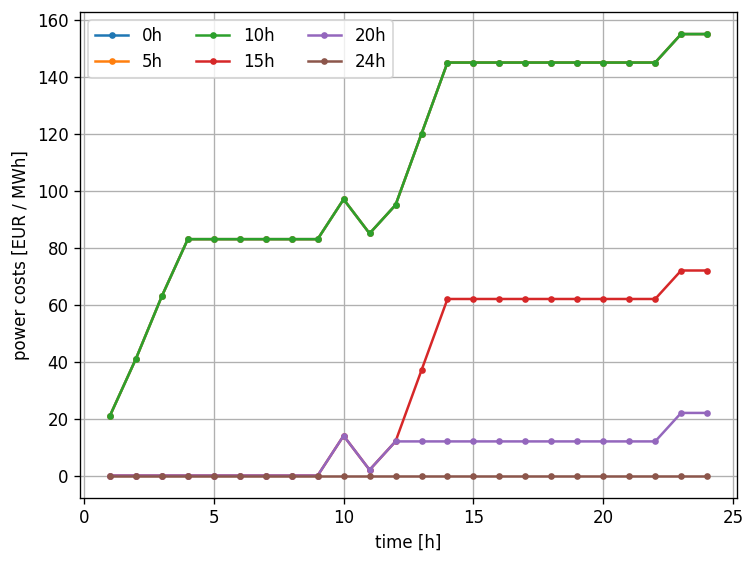

In [9]:
fig, ax = plt.subplots(dpi=120)

for key in output_dict.keys():
    (-1 * output_dict[key]['power_price'] * output_dict[key]['net_power']).where(output_dict[key]['net_power'] <= 0, 0).cumsum().plot(style=".-", label=key)

ax.set_ylabel('power costs [EUR / MWh]')
ax.set_xlabel('time [h]')
ax.legend(ncol=3)
ax.grid()

fig.tight_layout()

Power revenue

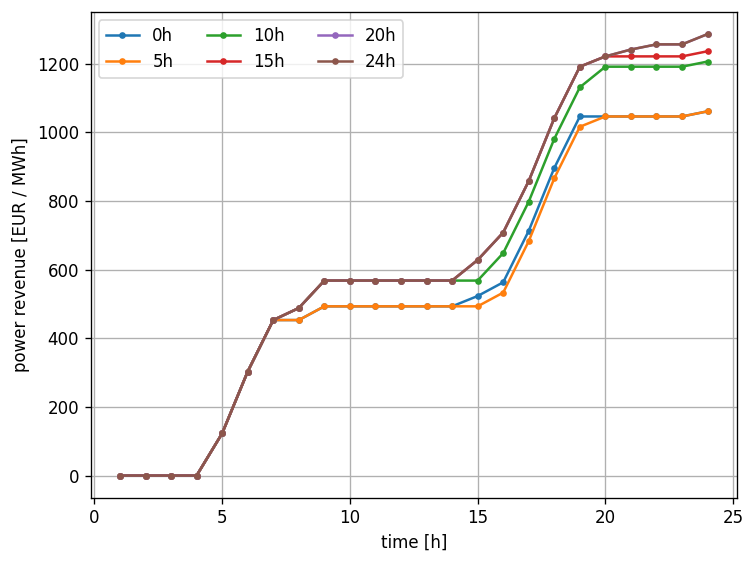

In [10]:
fig, ax = plt.subplots(dpi=120)

for key in output_dict.keys():
    (output_dict[key]['power_price'] * output_dict[key]['net_power']).where(output_dict[key]['net_power'] >= 0, 0).cumsum().plot(style=".-", label=key)

ax.set_ylabel('power revenue [EUR / MWh]')
ax.set_xlabel('time [h]')
ax.legend(ncol=3)
ax.grid()

fig.tight_layout()

### Plot cumulative costs

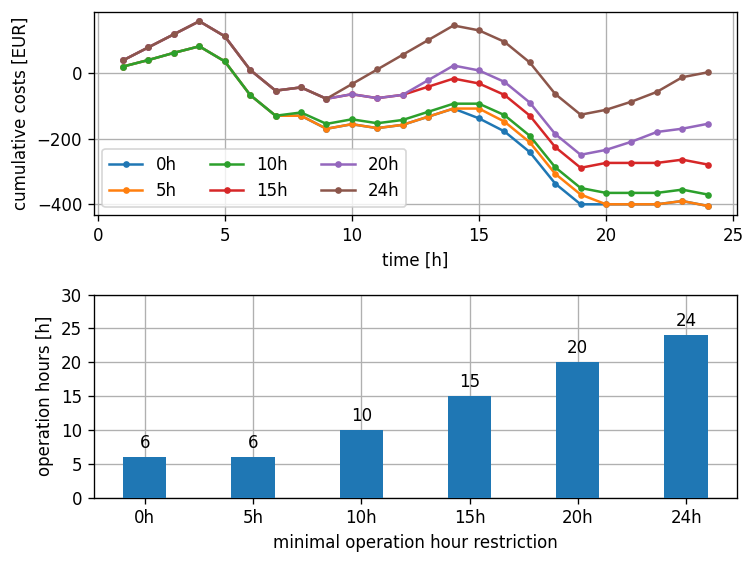

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=120)

for key in output_dict.keys():
    gas_costs = output_dict[key]['bhkw_gas'] * output_dict[key]['gas_price']
    power_costs = output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0) * output_dict[key]['power_price']
    power_revenue = output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0) * output_dict[key]['power_price']
    costs = gas_costs - power_costs - power_revenue

    costs.cumsum().plot(ax=ax1, style=".-", label=key)

ax1.set_ylabel('cumulative costs [EUR]')
ax1.set_xlabel('time [h]')
ax1.legend(ncol=3)
ax1.grid()

rects = ax2.bar(bin_data.keys(), bin_data.values(), width=0.4, zorder=3)
ax2.bar_label(rects, padding=3)
ax2.set_ylim(0, 30)
ax2.set_ylabel('operation hours [h]')
ax2.set_xlabel('minimal operation hour restriction')
ax2.grid(zorder=0)

fig.tight_layout()


### Combined energy and costs plots

Gas

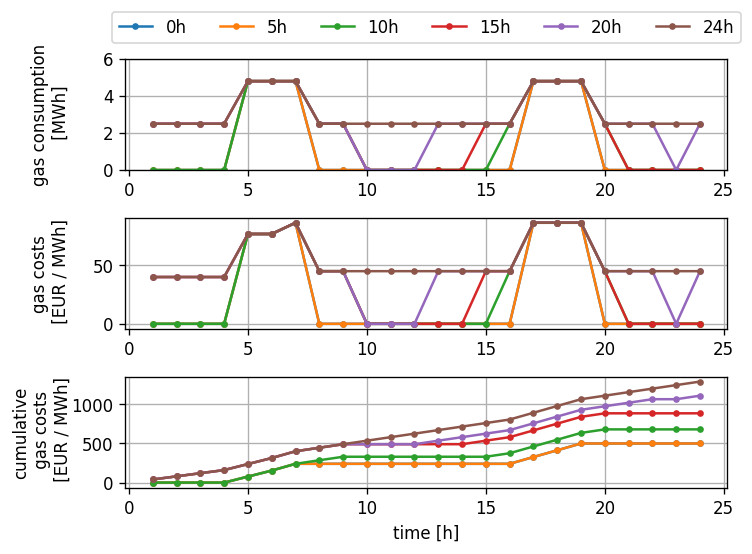

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=120)
for key in output_dict.keys():
    output_dict[key]['bhkw_gas'].plot(style=".-", label=key, ax=ax1)
ax1.set_ylabel('gas consumption\n [MWh]')
ax1.yaxis.labelpad = 20
ax1.set_ylim(0, 6)
ax1.legend(ncol=6, loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax1.grid()


for key in output_dict.keys():
    (output_dict[key]['gas_price'] * output_dict[key]['bhkw_gas']).plot(style=".-", label=key, ax=ax2)

ax2.set_ylabel('gas costs\n [EUR / MWh]')
ax2.yaxis.labelpad = 14
ax2.grid()


for key in output_dict.keys():
    (output_dict[key]['gas_price'] * output_dict[key]['bhkw_gas']).cumsum().plot(style=".-", label=key, ax=ax3)

ax3.set_ylabel('cumulative\n gas costs\n [EUR / MWh]')
ax3.yaxis.labelpad = 0
ax3.set_xlabel('time [h]')
ax3.grid()

fig.tight_layout()

Power cost

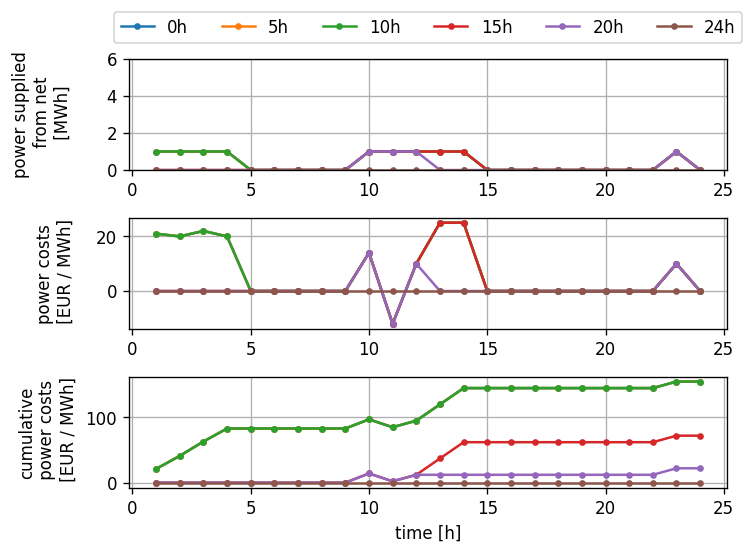

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=120)
for key in output_dict.keys():
    (-1
     * output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0)
     ).plot(style=".-", label=key, ax=ax1)
ax1.set_ylabel('power supplied\n from net\n [MWh]')
ax1.yaxis.labelpad = 21
ax1.set_ylim(0, 6)
ax1.legend(ncol=6, loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax1.grid()


for key in output_dict.keys():
    (-1
     * output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0)
     * output_dict[key]['power_price']
     ).plot(style=".-", label=key, ax=ax2)

ax2.set_ylabel('power costs\n [EUR / MWh]')
ax2.yaxis.labelpad = 13
ax2.grid()


for key in output_dict.keys():
    (-1
     * output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0)
     * output_dict[key]['power_price']
     ).cumsum().plot(style=".-", label=key, ax=ax3)

ax3.set_ylabel('cumulative\n power costs\n [EUR / MWh]')
ax3.yaxis.labelpad = 5
ax3.set_xlabel('time [h]')
ax3.grid()

fig.tight_layout()

Power revenue

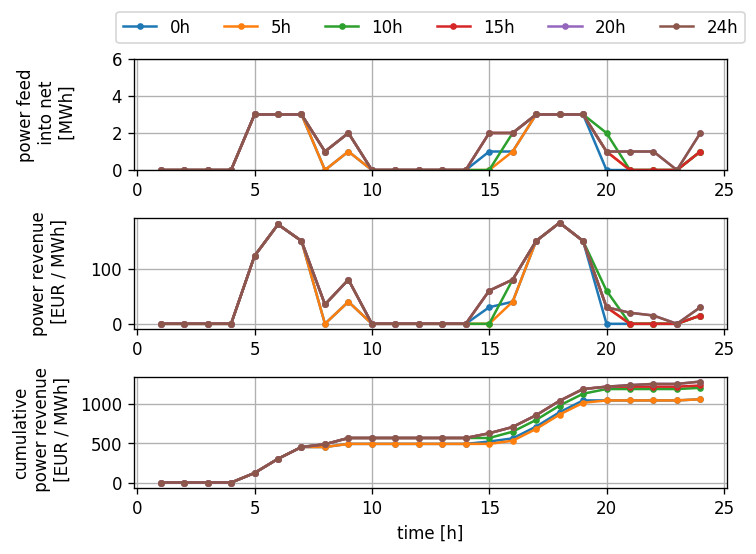

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=120)
for key in output_dict.keys():
    (output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0)
     ).plot(style=".-", label=key, ax=ax1)
ax1.set_ylabel('power feed\n into net\n [MWh]')
ax1.yaxis.labelpad = 21
ax1.set_ylim(0, 6)
ax1.legend(ncol=6, loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax1.grid()


for key in output_dict.keys():
    (output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0)
     * output_dict[key]['power_price']
     ).plot(style=".-", label=key, ax=ax2)

ax2.set_ylabel('power revenue\n [EUR / MWh]')
ax2.yaxis.labelpad = 13
ax2.grid()


for key in output_dict.keys():
    (output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0)
     * output_dict[key]['power_price']
     ).cumsum().plot(style=".-", label=key, ax=ax3)

ax3.set_ylabel('cumulative\n power revenue\n [EUR / MWh]')
ax3.yaxis.labelpad = 5
ax3.set_xlabel('time [h]')
ax3.grid()

fig.tight_layout()

### Plot total energy demand/supply

{'gas_demand': [28.8, 28.8, 38.8, 51.3, 63.8, 73.8], 'net_supply': [10.0, 10.0, 10.0, 6.0, 4.0, -0.0], 'net_feedin': [22.0, 22.0, 26.0, 27.0, 30.0, 30.0]}
[0 1 2 3 4 5]


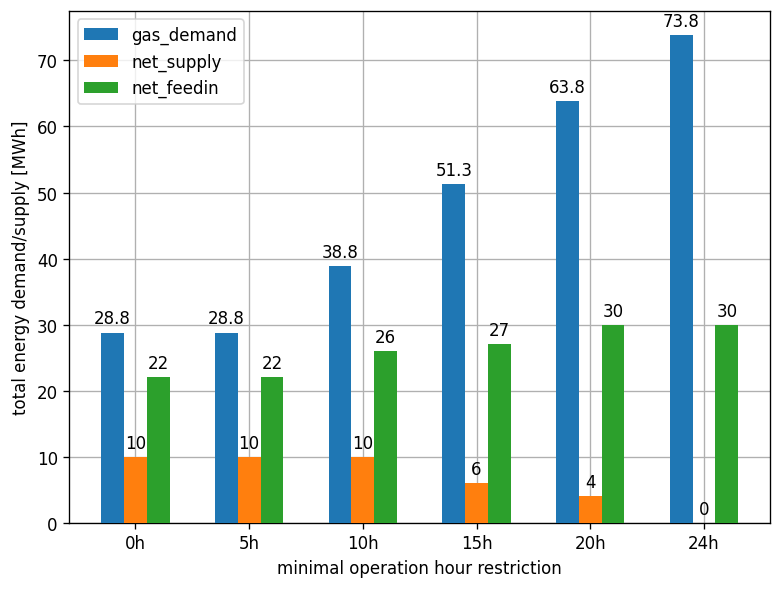

In [66]:
energy_data = {}
gas_demand = []
net_supply = []
net_feedin = []

for key in output_dict.keys():
    gas_demand.append(output_dict[key]['bhkw_gas'].sum().round(1))
    net_supply.append(-1 * output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0).sum().round(1))
    net_feedin.append(output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0).sum().round(1))

energy_data['gas_demand'] = gas_demand
energy_data['net_supply'] = net_supply
energy_data['net_feedin'] = net_feedin

print(energy_data)

x = np.arange(len(output_dict.keys()))
print(x)
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained', dpi=120)

for key, value in energy_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=key, zorder=3)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, power_flow_data.keys())
ax.set_ylabel('total energy demand/supply [MWh]')
ax.set_xlabel('minimal operation hour restriction')
ax.legend()
ax.grid(zorder=0)

Total costs

{'gas_costs': [499.0, 499.0, 679.0, 884.0, 1109.0, 1289.0], 'power_costs': [155.0, 155.0, 155.0, 72.0, 22.0, 0.0], 'power_revenue': [1061.0, 1061.0, 1206.0, 1236.0, 1286.0, 1286.0]}
[0 1 2 3 4 5]


C:\Users\mhafeman\AppData\Local\Temp\ipykernel_15644\3929796395.py:38: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


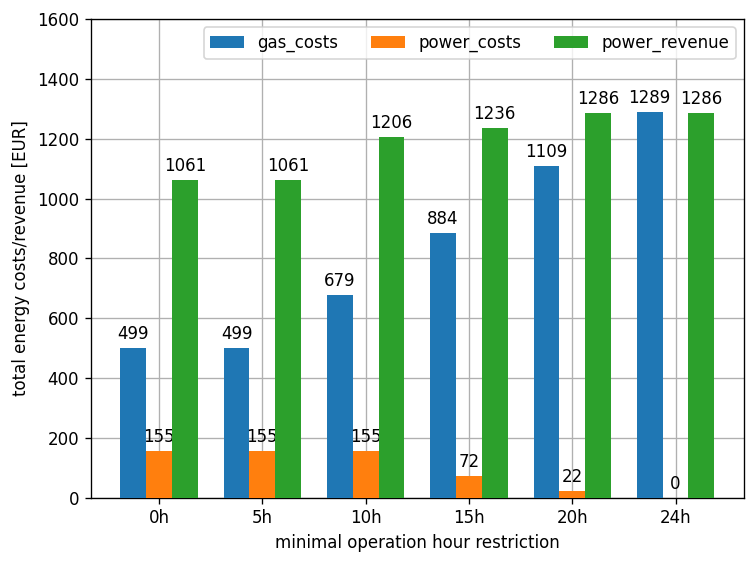

In [67]:
cost_data = {}
gas_costs = []
power_costs = []
power_revenue = []

for key in output_dict.keys():
    gas_costs.append((output_dict[key]['bhkw_gas'] * output_dict[key]['gas_price']).sum().round(0))
    power_costs.append((-1 * output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0) * output_dict[key]['power_price']).sum())
    power_revenue.append((output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0) * output_dict[key]['power_price']).sum())


cost_data['gas_costs'] = gas_costs
cost_data['power_costs'] = power_costs
cost_data['power_revenue'] = power_revenue

print(cost_data)

x = np.arange(len(output_dict.keys()))
print(x)
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained', dpi=120)

for key, value in cost_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=key, zorder=3)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, power_flow_data.keys())
ax.set_ylabel('total energy costs/revenue [EUR]')
ax.set_xlabel('minimal operation hour restriction')
ax.set_ylim(0, 1600)
ax.legend(ncol=3)
ax.grid(zorder=0)

fig.tight_layout()

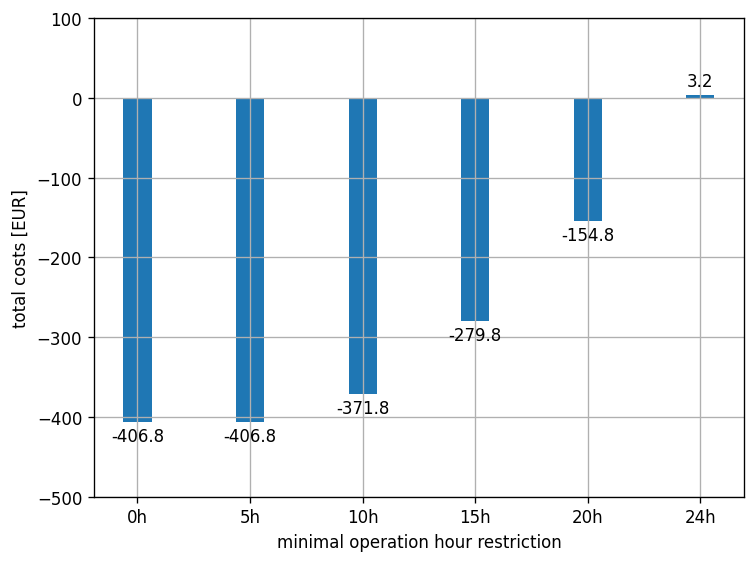

In [56]:
fig, ax = plt.subplots(dpi=120)

total_cost_data = {}

for key in output_dict.keys():
    gas_costs = output_dict[key]['bhkw_gas'] * output_dict[key]['gas_price']
    power_costs = output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0) * output_dict[key]['power_price']
    power_revenue = output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0) * output_dict[key]['power_price']
    costs = gas_costs - power_costs - power_revenue

    total_cost_data[key] = costs.sum()

bars = ax.bar(cost_data.keys(), total_cost_data.values(), width=0.25, zorder=3)
ax.bar_label(bars, padding=3)
ax.set_ylim(-500, 100)
ax.set_ylabel('total costs [EUR]')
ax.set_xlabel('minimal operation hour restriction')
ax.grid(zorder=0)

fig.tight_layout()

[0 1 2 3 4 5]


C:\Users\mhafeman\AppData\Local\Temp\ipykernel_15644\2040136777.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


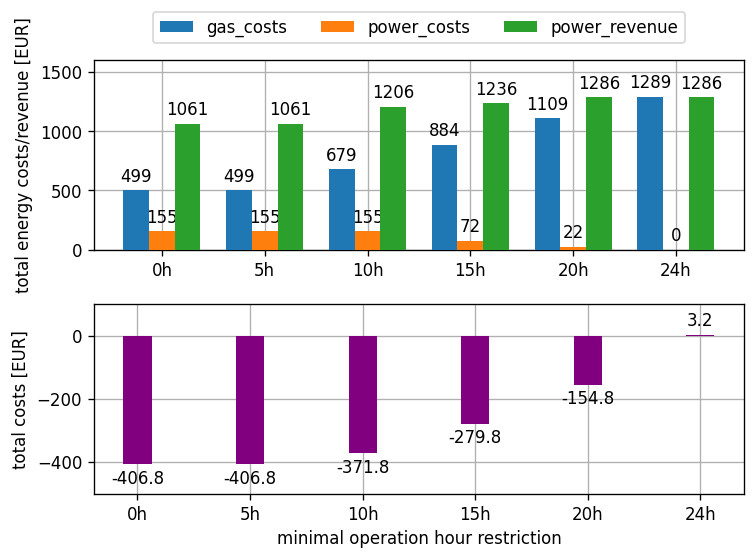

In [73]:
cost_data = {}
total_cost_data = {}
gas_costs = []
power_costs = []
power_revenue = []

for key in output_dict.keys():
    gas_costs.append((output_dict[key]['bhkw_gas'] * output_dict[key]['gas_price']).sum().round(0))
    power_costs.append((-1 * output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0) * output_dict[key]['power_price']).sum())
    power_revenue.append((output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0) * output_dict[key]['power_price']).sum())

cost_data['gas_costs'] = gas_costs
cost_data['power_costs'] = power_costs
cost_data['power_revenue'] = power_revenue


for key in output_dict.keys():
    gas_costs = output_dict[key]['bhkw_gas'] * output_dict[key]['gas_price']
    power_costs = output_dict[key]['net_power'].where(output_dict[key]['net_power'] <= 0, 0) * output_dict[key]['power_price']
    power_revenue = output_dict[key]['net_power'].where(output_dict[key]['net_power'] >= 0, 0) * output_dict[key]['power_price']
    costs = gas_costs - power_costs - power_revenue

    total_cost_data[key] = costs.sum()


x = np.arange(len(output_dict.keys()))
print(x)
width = 0.25
multiplier = 0

fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained', dpi=120)

for key, value in cost_data.items():
    offset = width * multiplier
    rects = ax1.bar(x + offset, value, width, label=key, zorder=3)
    ax1.bar_label(rects, padding=3)
    multiplier += 1

ax1.set_xticks(x + width, power_flow_data.keys())
ax1.set_ylabel('total energy costs/revenue [EUR]')
ax1.set_ylim(0, 1600)
ax1.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.3))
ax1.grid(zorder=0)

bars = ax2.bar(total_cost_data.keys(), total_cost_data.values(), width=0.25, zorder=3, color='purple')
ax2.bar_label(bars, padding=3)
ax2.set_ylim(-500, 100)
ax2.set_ylabel('total costs [EUR]')
ax2.set_xlabel('minimal operation hour restriction')
ax2.grid(zorder=0)

fig.tight_layout()

In [16]:
con_data = {}
con_1_powers = []
con_2_powers = []
con_3_powers = []
con_4_powers = []

for key in power_flow_data.keys():
    con_1_powers.append(power_flow_data[key]['bhkw_con_1_power'].sum())
    con_2_powers.append(power_flow_data[key]['bhkw_con_2_power'].sum())
    con_3_powers.append(power_flow_data[key]['storage_con_3_power'].sum())
    con_4_powers.append(power_flow_data[key]['net_con_4_power'].sum())

con_data['con_1'] = con_1_powers
con_data['con_2'] = con_2_powers
con_data['con_3'] = con_3_powers
con_data['con_4'] = con_4_powers

print(con_data)


{'con_1': [0.0, 0.0, 0.0, 4.0, 6.0, 10.0], 'con_2': [12.0, 12.0, 16.0, 17.0, 20.0, 20.0], 'con_3': [10.0, 10.0, 10.0, 10.0, 10.0, 10.0], 'con_4': [10.0, 10.0, 10.0, 6.0, 4.0, 0.0]}


[0 1 2 3 4 5]


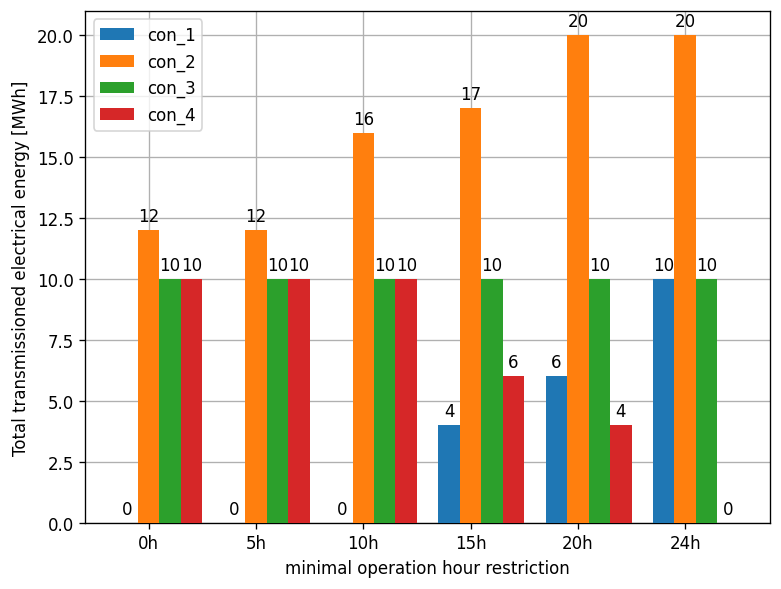

In [17]:
x = np.arange(len(power_flow_data.keys()))
print(x)
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained', dpi=120)

for key, value in con_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=key, zorder=3)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, power_flow_data.keys())
ax.set_ylabel('Total transmissioned electrical energy [MWh]')
ax.set_xlabel('minimal operation hour restriction')
ax.legend()
ax.grid(zorder=0)

### Create storage plot

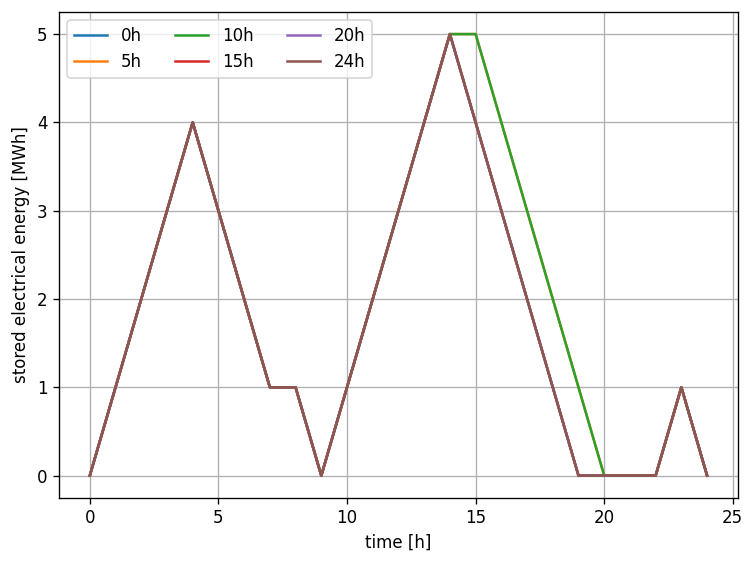

In [18]:
fig, ax1,= plt.subplots(dpi=120)

ax1.plot(pd.DataFrame(storage_data), label=cost_data.keys())
ax1.set_ylabel('stored electrical energy [MWh]')
ax1.set_xlabel('time [h]')
ax1.legend(ncol=3)
ax1.grid()

# rects = ax2.bar(bin_data.keys(), bin_data.values(), width=0.4, zorder=3)
# ax2.bar_label(rects, padding=3)
# ax2.set_ylim(0, 30)
# ax2.set_ylabel('operation hours [h]')
# ax2.set_xlabel('minimal operation hour restriction')
# ax2.grid(zorder=0)

fig.tight_layout()